# Transferencia de aprendizaje con MobileNetV2: Clasificación de alpaca vs no alpaca

Estaremos haciendo transferencia de aprendizaje en un CNN pre-entrenado para construir un clasificador Alpaca/Not Alpaca

<img src="https://github.com/jungsoh/tl-mobilenetv2-alpaca-vs-nonalpaca-classification/raw/main/images/alpaca.png" style="ancho:300px;alto:220px;">

Un modelo preentrenado es una red que ya se entrenó en un gran conjunto de datos y se guardó, lo que le permite usarlo para personalizar su propio modelo de manera económica y eficiente. El que usará, MobileNetV2, fue diseñado para proporcionar un rendimiento rápido y computacionalmente eficiente. Se ha entrenado previamente en [ImageNet](https://www.image-net.org/), un conjunto de datos que contiene más de 14 millones de imágenes y 1000 clases.

En este proyecto realizamos las siguientes tareas:
- Crear un conjunto de datos desde un directorio
- Preprocesar y aumentar los datos mediante la API secuencial
- Adapte un modelo previamente entrenado a nuevos datos y entrene un clasificador utilizando la API funcional y MobileNet
- Ajuste las capas finales de un clasificador para mejorar la precisión

## Tabla de contenido

- [1 - Paquetes](#1)
- [2 - Crear el conjunto de datos y dividirlo en conjuntos de entrenamiento y validación](#2)
- [3 - Preprocesar y aumentar datos de entrenamiento](#3)
- [4 - Uso de MobileNetV2 para transferencia de aprendizaje](#4)
     - [4.1 - Dentro de un bloque de construcción convolucional de MobileNetV2](#4-1)
     - [4.2 - Congelación de capas con la API funcional](#4-2)
     - [4.3 - Fine Tunning del modelo](#4-3)
- [5 - Trabajando con clasificación multiple](#5)
     

<a name='1'></a>
## 1 - Paquetes

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from google.colab import drive
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


## 2 - Crear conjuntos de datos de entrenamiento y validación

Agregamos acceso a Google Drive para cargar los archivos para entrenar el modelo

Al entrenar y evaluar modelos de aprendizaje profundo en Keras, llamamos a `image_data_set_from_directory()` para leer desde el directorio y crear conjuntos de datos de entrenamiento y validación.

Si está especificando una división de validación, también deberá especificar el subconjunto para cada parte. Simplemente configure el conjunto de entrenamiento en `subset='training'` y el conjunto de validación en `subset='validation'`.

También configurará sus semillas para que coincidan entre sí, de modo que sus conjuntos de entrenamiento y validación no se superpongan. 

El conjunto de datos contiene imágenes JPG de 2 clase de Alpaca y No Alpaca :)

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
drive.mount('/content/drive')
directory = '/content/drive/MyDrive/Master/Asignaturas/4 - Aprendizaje Profundo AP/mbnv2/dataset_1/'
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Ahora echemos un vistazo a algunas de las imágenes del conjunto de entrenamiento. El conjunto de datos original también tiene algunas imágenes mal etiquetadas.

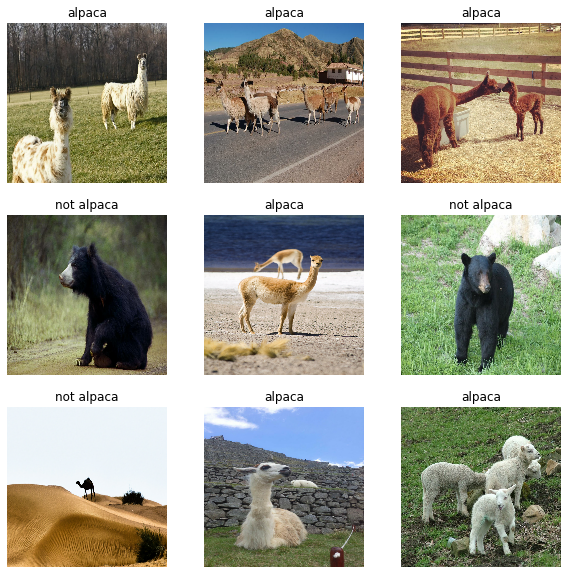

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 3 - Preprocesar y aumentar los datos de entrenamiento

El uso de `dataset.prefetch()` evita un cuello de botella en la memoria que puede ocurrir al leer desde el disco. Reserva algunos datos y los mantiene listos para cuando se necesiten, creando un conjunto de datos de origen a partir de sus datos de entrada, aplicando una transformación para preprocesarlos y luego iterando sobre el conjunto de datos un elemento a la vez. Debido a que la iteración se transmite, los datos no necesitan caber en la memoria.

Puede configurar el número de elementos para precargar manualmente, o puede usar `tf.data.experimental.AUTOTUNE` para elegir los parámetros automáticamente. Autotune solicita `tf.data` para ajustar ese valor dinámicamente en tiempo de ejecución, rastreando el tiempo empleado en cada operación e ingresando esos tiempos en un algoritmo de optimización. El algoritmo de optimización intenta encontrar la mejor asignación de su presupuesto de CPU en todas las operaciones ajustables.

Para aumentar la diversidad en el conjunto de entrenamiento y ayudar a su modelo a aprender mejor los datos, es una práctica estándar aumentar las imágenes transformándolas, por ejemplo, volteándolas y girándolas aleatoriamente. Keras Sequential API ofrece un método sencillo para este tipo de aumentos de datos, con capas de preprocesamiento integradas y personalizables. Estas capas se guardan con el resto de su modelo y se pueden reutilizar más tarde. La documentación oficial para [aumento de datos](https://www.tensorflow.org/tutorials/images/data_augmentation) explica los detalles.

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

Implementar una función para el aumento de datos. Utilice un modelo de keras `Secuencial` compuesto por 2 capas:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [6]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

In [7]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
print('\033[92mAll tests passed!')

All tests passed!


Eche un vistazo a cómo se ha aumentado una imagen del conjunto de entrenamiento con transformaciones simples. A partir de un lindo anima generamos 9 variaciones de ese lindo animal, en tres líneas de código.

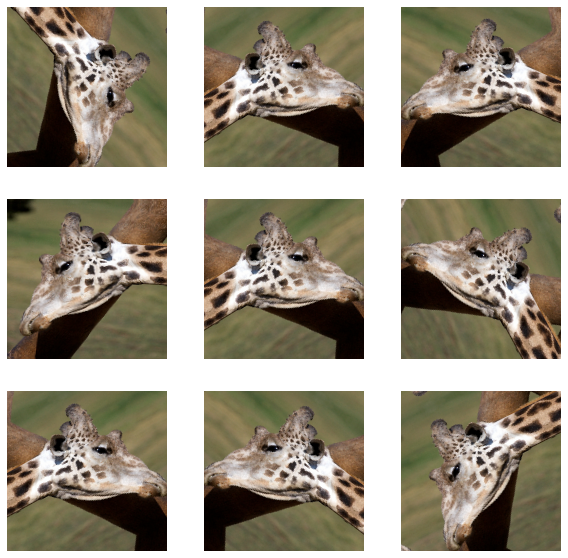

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

A continuación, aplicará su primera herramienta de la aplicación MobileNet en TensorFlow para normalizar su entrada. Dado que está utilizando un modelo previamente entrenado que se entrenó en los valores de normalización [-1,1], es una buena práctica reutilizar ese estándar con `tf.keras.applications.mobilenet_v2.preprocess_input`.

Estos son los puntos a recordar:
* Al llamar a `image_data_set_from_directory()`, especifique los subconjuntos de entrenamiento/validación y haga coincidir las semillas para evitar la superposición
* Usar `prefetch()` para evitar cuellos de botella en la memoria al leer desde el disco
* Proporcionar a su modelo más datos para aprender con aumentos de datos simples como rotación y volteo
* Cuando se usa un modelo previamente entrenado, es mejor reutilizar los pesos con los que se entrenó

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## 4 - Utilice MobileNetV2 para el aprendizaje por transferencia

MobileNetV2 se entreno en ImageNet y está optimizado para ejecutarse en aplicaciones móviles y otras aplicaciones de bajo consumo. Tiene 155 capas de profundidad y es muy eficiente para tareas de detección de objetos y segmentación de imágenes, así como tareas de clasificación como esta. La arquitectura tiene tres características definitorias:

* Depthwise separable convolutions
* Capas bottlenecks en sus entradas y salidas
* Conexiones de acceso directo entre capas bottlenecks

### 4.1 - Dentro de un bloque de construcción convolucional MobileNetV2

MobileNetV2 utiliza Depthwise separable convolutions como bloques de construcción eficientes. Las convoluciones tradicionales a menudo consumen muchos recursos, y las Depthwise separable convolutions pueden reducir la cantidad de parámetros y operaciones entrenables y también acelerar las convoluciones en dos pasos:

1. El primer paso calcula un resultado intermedio convolucionando en cada uno de los canales de forma independiente. Esta es la depthwise convolution..
2. En el segundo paso, otra convolución fusiona las salidas del paso anterior en una sola. Esto obtiene un solo resultado de una sola entidad a la vez y luego se aplica a todos los filtros en la capa de salida. Esta es la pointwise convolution, o: **Forma de las Capas Inverted Residual con Bottneleck por X Número de filtros.**

<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>MobileNetV2 Architecture</b> <br> This diagram was inspired by this <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">original figure</a>.</center></caption>

Cada bloque consta de una estructura **inverted residual** con un **bottleneck** en cada extremo. Estos **bottleneck** codifican las entradas y salidas intermedias en un espacio dimensional bajo y evitan que las no linealidades **ReLU6** destruyan información importante.

Las **shortcut connections**, que son similares a las de las residual networks, cumplen el mismo propósito de acelerar el entrenamiento y mejorar las predicciones. Estas conexiones saltan las circunvoluciones intermedias y conectan las capas **bottleneck**.

Intentemos entrenar el modelo base usando todas las capas del modelo previamente entrenado.

De manera similar a cómo reutilizó los valores de normalización preentrenados en los que se entrenó MobileNetV2, también cargará los pesos preentrenados de ImageNet especificando `weights='imagenet'`.

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

Imprimimos el resumen del modelo a continuación para ver todas las capas del modelo, las formas de sus resultados y la cantidad total de parámetros, entrenables y no entrenables.

In [11]:
base_model.summary()
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

Las dos últimas capas son las llamadas capas superiores y son responsables de la clasificación por parte del modelo.

In [12]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


Observe algunas de las capas en el resumen como `Conv2D` y `DepthwiseConv2D` y cómo siguen la progresión de la expansión a la convolución en profundidad a la proyección. En combinación con BatchNormalization y ReLU, forman las capas **bottleneck** mencionadas anteriormente.

Estos son puntos para recordar:

* Las características únicas de MobileNetV2 son:
   * Las **Depthwise separable convolutions** brindan filtrado y creación de características livianas
   * Las **bottlenecks** de entrada y salida que conservan información importante en cualquier extremo del bloque
* Las Depthwise separable convolutions  se ocupan de las dimensiones espaciales y de profundidad (número de canales)

Luego, elija el primer lote del conjunto de datos de TensorFlow para usar las imágenes y ejecútelo a través del modelo base de MobileNetV2 para probar las predicciones en algunas de sus imágenes. 

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [14]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

Ahora decodifique las predicciones hechas por el modelo. Anteriormente, cuando imprimió la forma del lote, habría regresado (32, 1000). El número 32 se refiere al tamaño del lote y 1000 se refiere a las 1000 clases en las que se entrenó previamente el modelo. Las predicciones devueltas por el modelo base a continuación siguen este formato:

1. número de clase
2. una etiqueta legible por humanos
3. probabilidad de que la imagen pertenezca a esa clase

Se devuelven dos predicciones para cada imagen del lote, que corresponden a las dos probabilidades principales.

In [15]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.425822),
  ('n02708093', 'analog_clock', 0.09275593)],
 [('n04589890', 'window_screen', 0.23985961),
  ('n03887697', 'paper_towel', 0.14802647)],
 [('n04589890', 'window_screen', 0.74494576),
  ('n03598930', 'jigsaw_puzzle', 0.021948503)],
 [('n04589890', 'window_screen', 0.33546028),
  ('n03530642', 'honeycomb', 0.0762893)],
 [('n04589890', 'window_screen', 0.27327326),
  ('n03733281', 'maze', 0.08846968)],
 [('n04589890', 'window_screen', 0.6745254),
  ('n03530642', 'honeycomb', 0.07659869)],
 [('n04589890', 'window_screen', 0.79128575),
  ('n04209239', 'shower_curtain', 0.09241592)],
 [('n04589890', 'window_screen', 0.16462986),
  ('n03598930', 'jigsaw_puzzle', 0.087491855)],
 [('n03598930', 'jigsaw_puzzle', 0.37021384),
  ('n04589890', 'window_screen', 0.09956942)],
 [('n04589890', 'window_screen', 0.6161673),
  ('n03887697', 'paper_towel', 0.054876637)],
 [('n03530642', 'honeycomb', 0.25448844),
  ('n04589890', 'window_screen', 0.24874416)],
 [('

Hay un montón de etiquetas aquí, algunas de ellas hilarantemente incorrectas, pero ninguna de ellas dice "alpaca". Esto se debe a que MobileNet preentrenado sobre ImageNet no tiene las etiquetas correctas para alpacas, por lo que cuando usa el modelo completo, todo lo que obtiene es un montón de imágenes clasificadas incorrectamente. Puede eliminar la capa superior, que contiene todas las etiquetas de clasificación, y crear una nueva capa de clasificación.

### 4.2 - Congelar capas con la API funcional

<img src="imagen/snowalpaca.png" style="ancho:400px;alto:250px;">

En las siguientes secciones, verá cómo puede usar un modelo previamente entrenado para modificar la tarea del clasificador para que pueda reconocer alpacas. Puedes lograr esto en tres pasos:

1. Eliminar la capa superior (la capa de clasificación)
     * Establecer `include_top` en `base_model` como Falso
2. Agregar una nueva capa clasificadora
     * Entrene solo una capa congelando el resto de la red
     * Como se mencionó anteriormente, una sola neurona es suficiente para resolver un problema de clasificación binaria.
3. Congele el modelo base y entrene la capa clasificadora recién creada
     * Establecer `base model.trainable=False` para evitar cambiar los pesos y entrenar *solo* la nueva capa
     * Establezca el entrenamiento en `base_model` en Falso para evitar realizar un seguimiento de las estadísticas en la capa de norma por lotes

In [16]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' 
    Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
        
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1)(x)
        
    model = tf.keras.Model(inputs, outputs)
    
    return model

Cree su nuevo modelo utilizando la función data_augmentation definida anteriormente.

In [17]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [18]:
!pip install test-utils
# from test_utils import summary #, comparator

alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

# comparator(summary(model2), alpaca_summary)

# for layer in summary(model2):
    # print(layer)
    

La tasa de aprendizaje base se ha establecido, por lo que puede seguir adelante y compilar el nuevo modelo y ejecutarlo durante 5 épocas:

In [19]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 22s 2s/step - loss: 0.7451 - accuracy: 0.5649 - val_loss: 0.6627 - val_accuracy: 0.5538
Epoch 2/5
9/9 [==============================] - 8s 721ms/step - loss: 0.6704 - accuracy: 0.5954 - val_loss: 0.5663 - val_accuracy: 0.6154
Epoch 3/5
9/9 [==============================] - 8s 706ms/step - loss: 0.5065 - accuracy: 0.7290 - val_loss: 0.5174 - val_accuracy: 0.6615
Epoch 4/5
9/9 [==============================] - 8s 711ms/step - loss: 0.4354 - accuracy: 0.7748 - val_loss: 0.4779 - val_accuracy: 0.7077
Epoch 5/5
9/9 [==============================] - 9s 729ms/step - loss: 0.4297 - accuracy: 0.7748 - val_loss: 0.4180 - val_accuracy: 0.7231


Plot the training and validation accuracy:

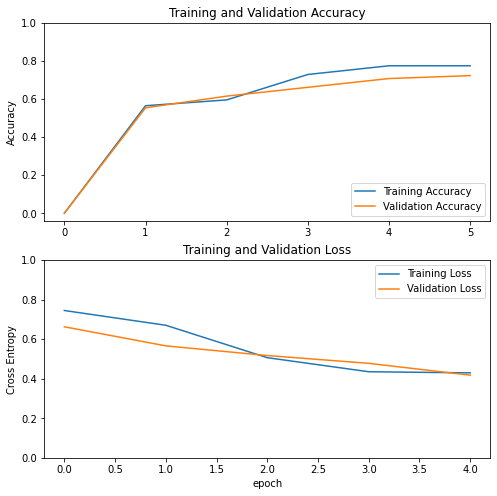

In [21]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
class_names

['alpaca', 'not alpaca']

The results are ok, but could be better. Next, try some fine-tuning.

### 4.3 - Afinar el modelo

Puede intentar ajustar el modelo volviendo a ejecutar el optimizador en las últimas capas para mejorar la precisión. Cuando usa una tasa de aprendizaje más pequeña, toma pasos más pequeños para adaptarla un poco más a los nuevos datos. En el aprendizaje por transferencia, la forma de lograr esto es descongelando las capas al final de la red y luego volviendo a entrenar su modelo en las capas finales con una tasa de aprendizaje muy baja.

La intuición de lo que está sucediendo: cuando la red se encuentra en sus primeras etapas, se entrena en características de bajo nivel, como los bordes. En las capas posteriores, comienzan a emerger características más complejas y de alto nivel, como cabello ralo u orejas puntiagudas. Para el aprendizaje por transferencia, las características de bajo nivel se pueden mantener iguales, ya que tienen características comunes para la mayoría de las imágenes. Cuando agrega nuevos datos, generalmente desea que las características de alto nivel se adapten a ellos, lo que es como dejar que la red aprenda a detectar características más relacionadas con sus datos, como un pelaje suave o dientes grandes.

Para lograr esto, simplemente descongele las capas finales y vuelva a ejecutar el optimizador con una tasa de aprendizaje menor, mientras mantiene todas las demás capas congeladas.

Primero, descongele el modelo base configurando `base_model.trainable=True`, configure una capa desde la que ajustar, luego vuelva a congelar todas las capas anteriores. Vuelva a ejecutarlo durante algunas épocas más y vea si su precisión mejoró.

In [23]:
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
assert type(loss_function) == tf.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')

All tests passed!


In [25]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 25s 2s/step - loss: 0.5091 - accuracy: 0.7519 - val_loss: 0.2494 - val_accuracy: 0.8615
Epoch 6/10
9/9 [==============================] - 12s 955ms/step - loss: 0.2904 - accuracy: 0.8702 - val_loss: 0.1673 - val_accuracy: 0.9385
Epoch 7/10
9/9 [==============================] - 11s 955ms/step - loss: 0.2093 - accuracy: 0.9046 - val_loss: 0.1923 - val_accuracy: 0.8769
Epoch 8/10
9/9 [==============================] - 11s 1s/step - loss: 0.1617 - accuracy: 0.9504 - val_loss: 0.1355 - val_accuracy: 0.9231
Epoch 9/10
9/9 [==============================] - 11s 983ms/step - loss: 0.1050 - accuracy: 0.9733 - val_loss: 0.0785 - val_accuracy: 0.9692
Epoch 10/10
9/9 [==============================] - 11s 997ms/step - loss: 0.1305 - accuracy: 0.9542 - val_loss: 0.1072 - val_accuracy: 0.9538


Tenemos bastante mejoría. Un pequeño ajuste realmente puede recorrer un gran camino.

In [26]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

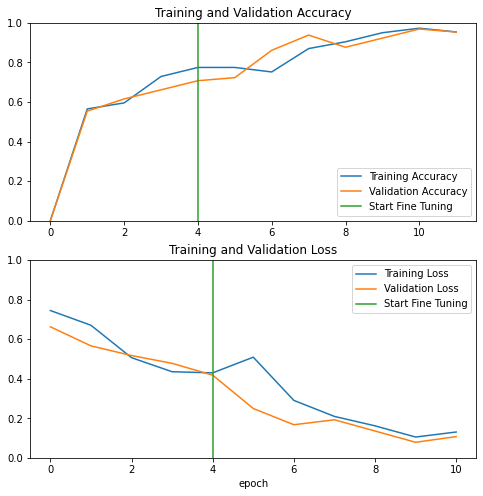

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

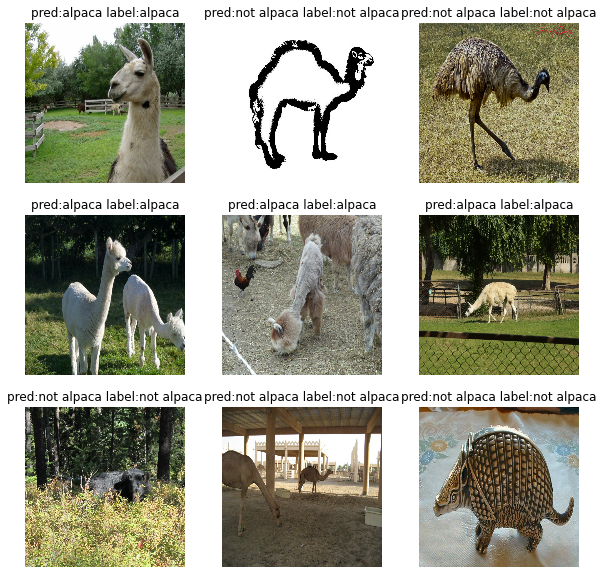

In [28]:
class_names = validation_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    image_var = tf.Variable(images)
    pred = model2.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        p = "alpaca" if pred[i] < 0 else "not alpaca"
        plt.title("pred:{} label:{}".format(p,class_names[labels[i]]))
        plt.axis("off")

Estos son puntos para recordar:

* Para adaptar el clasificador a nuevos datos, elimine la capa superior, agregue una nueva capa de clasificación y entrene solo en esa capa
* Al congelar capas, evite realizar un seguimiento de las estadísticas (como en la capa de normalización por lotes)
* Ajuste las capas finales de su modelo para capturar detalles de alto nivel cerca del final de la red y mejorar potencialmente la precisión

Este es un resumen rápido de todo lo que logramos con este proyecto sobre transferencia de aprendizaje y ajuste.

* Creado un conjunto de datos de un directorio
* Datos aumentados con la API secuencial
* Adaptado un modelo preentrenado a nuevos datos con la API funcional y MobileNetV2
* Afinamos las capas finales del clasificador y aumentamos la precisión del modelo.

### 5. Trabajando con clasificación multiple
Para trabajar con Clasificación multiple debemos modificar la ultima capa del modelo por una que posea mas Neuronas para clasificar. Ademas debe tener otra función de activación y otra entropia.

Para esta actividad utilizamosdatos de Cars Dataset bassed Stanford https://www.kaggle.com/datasets/boulahchichenadir/algerian-used-cars las cuales son 20 clases de distintos automoviles en Argelia

la funcion `image_dataset_from_directory` requiere que definamos que utilizaremos multiples categorias con `label_mode='categorical'` al momento de hacer `model.fit`


In [29]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
drive.mount('/content/drive')
directory = '/content/drive/MyDrive/Master/Asignaturas/4 - Aprendizaje Profundo AP/mbnv2/dataset_2/'
train_dataset2 = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42,
                                             label_mode='categorical')
validation_dataset2 = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42,
                                             label_mode='categorical')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3235 files belonging to 20 classes.
Using 2588 files for training.
Found 3235 files belonging to 20 classes.
Using 647 files for validation.


In [33]:
# class_names2 = train_dataset2.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset2.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names2[labels[i]])
#         plt.axis("off")

In [34]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset2 = train_dataset2.prefetch(buffer_size=AUTOTUNE)
augmenter = data_augmenter()

In [35]:
assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
print('\033[92mAll tests passed!')

All tests passed!


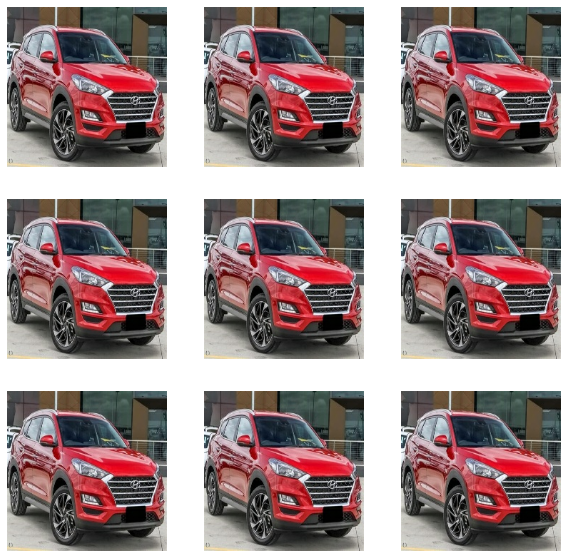

In [36]:
data_augmentation = data_augmenter()

for image, _ in train_dataset2.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')


In [37]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
nb_layers = len(base_model2.layers)
print(base_model2.layers[nb_layers - 2].name)
print(base_model2.layers[nb_layers - 1].name)

global_average_pooling2d_2
predictions


In [38]:
image_batch2, label_batch2 = next(iter(train_dataset2))
feature_batch2 = base_model(image_batch2)
print(feature_batch.shape)

(32, 1000)


In [39]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

Congelamos el modelo y trabajamos con nuestro clasificador utilizando `CategoricalCrossentropy`

In [40]:
def cars_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' 
    Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
        
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(20,activation=('softmax'))(x)
        
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [42]:
# no se si esta bien
model3 = cars_model(IMG_SIZE, data_augmentation)
cars_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 20), 1281, 'softmax']] #linear is the default activation

In [43]:
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [44]:
base_learning_rate = 0.001
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
initial_epochs = 5
history2 = model3.fit(train_dataset2, validation_data=validation_dataset2, epochs=initial_epochs)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


81/81 [==============================] - 69s 796ms/step - loss: 2.8948 - accuracy: 0.1646 - val_loss: 2.4636 - val_accuracy: 0.2767
Epoch 2/5
81/81 [==============================] - 65s 794ms/step - loss: 2.2824 - accuracy: 0.3184 - val_loss: 2.0947 - val_accuracy: 0.3988
Epoch 3/5
81/81 [==============================] - 65s 794ms/step - loss: 2.0126 - accuracy: 0.4096 - val_loss: 1.9508 - val_accuracy: 0.4312
Epoch 4/5
81/81 [==============================] - 66s 804ms/step - loss: 1.8033 - accuracy: 0.4451 - val_loss: 1.8400 - val_accuracy: 0.4498
Epoch 5/5
81/81 [==============================] - 65s 799ms/step - loss: 1.6964 - accuracy: 0.4815 - val_loss: 1.7402 - val_accuracy: 0.4714


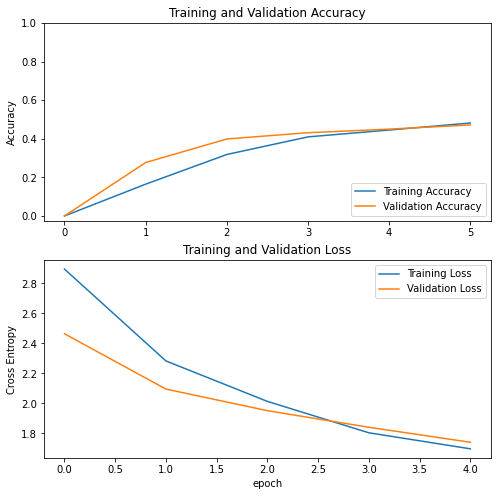

In [46]:
acc = [0.] + history2.history['accuracy']
val_acc = [0.] + history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Afinamos el Modelo

In [47]:
base_model2 = model3.layers[4]
base_model2.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model2.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model2.layers[:fine_tune_at]:
    layer.trainable = None
    
# Define a CategoricalCrossentropy loss function. Use from_logits=True
loss_function2=tf.losses.CategoricalCrossentropy(from_logits=False)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

model3.compile(loss=loss_function2,optimizer = optimizer,metrics=metrics)

Number of layers in the base model:  154


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [48]:
assert type(loss_function2) == tf.losses.CategoricalCrossentropy, "Not the correct layer"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"
print('\033[92mAll tests passed!')

All tests passed!


In [49]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine2 = model3.fit(train_dataset2,
                         epochs=total_epochs,
                         initial_epoch=history2.epoch[-1],
                         validation_data=validation_dataset2)

Epoch 5/15
81/81 [==============================] - 87s 1s/step - loss: 1.7705 - accuracy: 0.4614 - val_loss: 1.7891 - val_accuracy: 0.4389
Epoch 6/15
81/81 [==============================] - 82s 1s/step - loss: 1.4326 - accuracy: 0.5576 - val_loss: 1.3462 - val_accuracy: 0.5672
Epoch 7/15
81/81 [==============================] - 82s 1s/step - loss: 1.1693 - accuracy: 0.6236 - val_loss: 1.3054 - val_accuracy: 0.5781
Epoch 8/15
81/81 [==============================] - 83s 1s/step - loss: 0.9902 - accuracy: 0.6882 - val_loss: 1.0698 - val_accuracy: 0.6414
Epoch 9/15
81/81 [==============================] - 83s 1s/step - loss: 0.8411 - accuracy: 0.7388 - val_loss: 1.2051 - val_accuracy: 0.6430
Epoch 10/15
81/81 [==============================] - 83s 1s/step - loss: 0.7373 - accuracy: 0.7573 - val_loss: 0.8457 - val_accuracy: 0.7280
Epoch 11/15
81/81 [==============================] - 83s 1s/step - loss: 0.6393 - accuracy: 0.7913 - val_loss: 0.7567 - val_accuracy: 0.7589
Epoch 12/15
81/81 

In [50]:
acc += history_fine2.history['accuracy']
val_acc += history_fine2.history['val_accuracy']

loss += history_fine2.history['loss']
val_loss += history_fine2.history['val_loss']

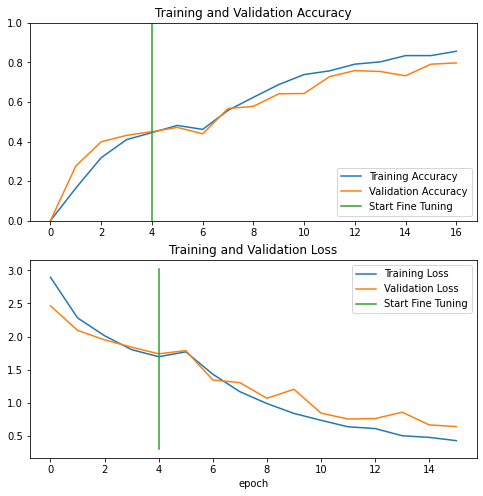

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(20,), dtype=float32)
(array([4]),)
predicion: {} {} 1 bmw serie 1
valor correcto: {} {} 4 clio
------------------
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(20,), dtype=float32)
(array([15]),)
predicion: {} {} 4 clio
valor correcto: {} {} 15 sandero
------------------
tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(20,), dtype=float32)
(array([2]),)
predicion: {} {} 11 nemo citroen
valor correcto: {} {} 2 chevrolet spark
------------------
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(20,), dtype=float32)
(array([13]),)
predicion: {} {} 10 mercedes class a
valor correcto: {} {} 13 picanto
------------------
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(20,), dtype=float32)
(array([17]),)
predicion: {} {} 16 seat ibiza
valor correcto: {} {} 17 symbol
------------------
tf.T

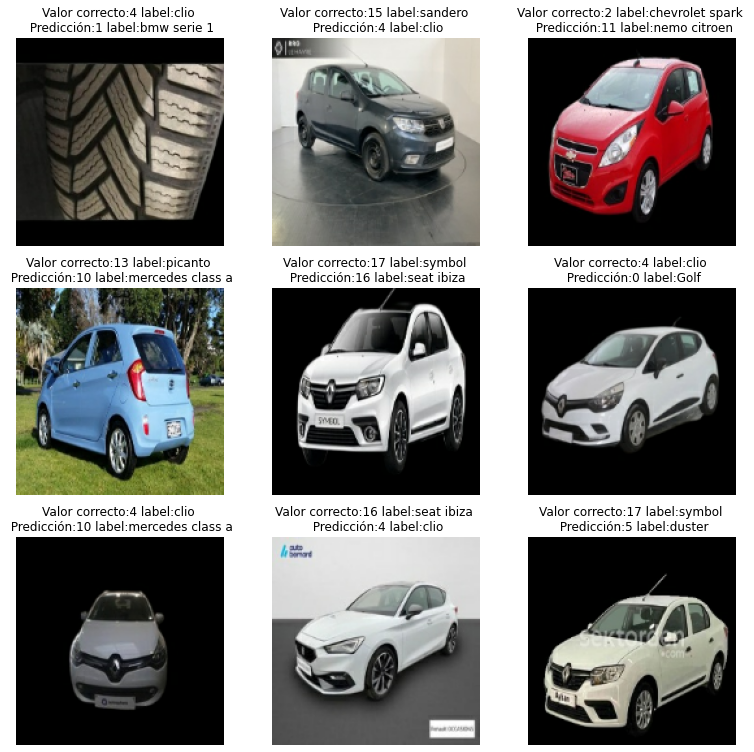

In [52]:
from keras.applications import mobilenet_v2
class_names2 = validation_dataset2.class_names
plt.figure(figsize=(13, 13))
for images, labels in validation_dataset2.take(1):
    image_var = tf.Variable(images)
    preds = model3.predict(images)
    labels_numpy = labels.numpy()

    for i in range(9):
      pred_order = preds.argsort()[::-1][i][0]
      label_correct = labels_numpy[i].argsort()[::-1][0]
      print(labels[i])
      print(np.where(labels[i] == 1))
      print("predicion: {} {}", pred_order, class_names2[pred_order])
      print("valor correcto: {} {}", label_correct, class_names2[label_correct])
      print("------------------")

      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title("Valor correcto:{} label:{} \n Predicción:{} label:{}".format(label_correct, class_names2[label_correct],
                                                     pred_order,
                                                     class_names2[pred_order]))
      plt.axis("off")